In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from itertools import batched

from micrograd.engine import Value
from micrograd.loss import hinge_loss
from micrograd.nn import Neuron, Layer, MLP

In [3]:
np.random.seed(1337)
random.seed(1337)

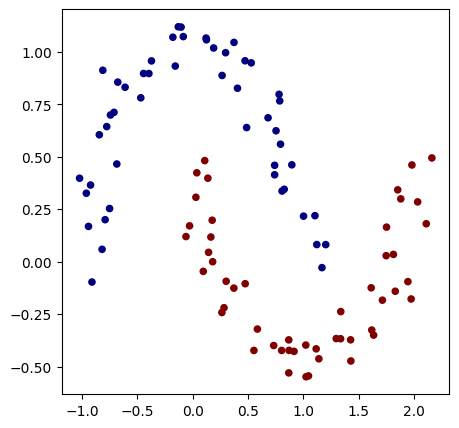

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
n = MLP(2, [16, 16, 1])

batch_size = 30

# Why are we permutating? Can we achieve the same thing with native batching?
# Does permutating improve the training performance?
# batched(zip(X, y), batch_size)

# maybe: what `loss()` doing is selecting training set randomly

def loss():
    if batch_size:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    else:
        Xb, yb = X, y

    # make the tuple of inputs into Value objects while maintaining the shape
    inputs = [list(map(Value, Xrow)) for Xrow in Xb]

    # forward pass for the inputs
    scores = list(map(n, inputs))

    # hinge loss, or SVM max-margin loss
    losses = hinge_loss(gt=yb, pred=scores)
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 Regularization
    lambda_ = 1e-4
    complexity = sum([p*p for p in n.parameters()])
    reg_loss = lambda_ * complexity

    total_loss = data_loss + reg_loss

    # Accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [6]:
steps = 100

for k in range(steps):
    # Forward
    total_loss, acc = loss()

    # Backward
    n.zero_grad()
    total_loss.backward()

    # Optimise
    learning_rate = 1.0 - 0.9*k/100
    for p in n.parameters():
        p.data -= learning_rate * p.grad

    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

print(f"step {steps} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.8082569633624987, accuracy 66.66666666666666%
step 10 loss 0.3201081343851115, accuracy 83.33333333333334%
step 20 loss 0.33322803507830845, accuracy 83.33333333333334%
step 30 loss 0.07191216250098569, accuracy 100.0%
step 40 loss 0.4225195729161026, accuracy 80.0%
step 50 loss 0.18487021806492596, accuracy 93.33333333333333%
step 60 loss 0.05868422234562089, accuracy 100.0%
step 70 loss 0.033356999871691426, accuracy 100.0%
step 80 loss 0.03429302303645687, accuracy 100.0%
step 90 loss 0.028192385645972748, accuracy 100.0%
step 100 loss 0.043122374553061914, accuracy 100.0%


(-1.548639298268643, 1.951360701731357)

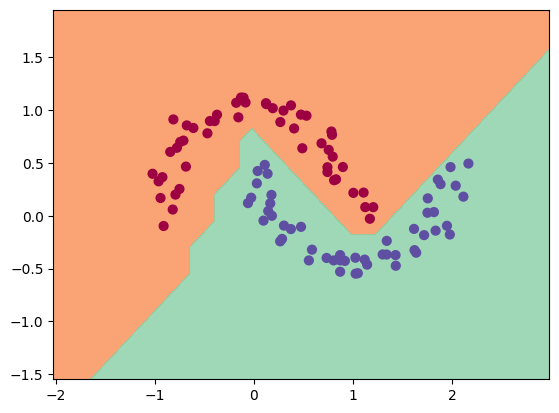

In [7]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(n, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())